In [ ]:
import os
import pandas as pd

def parse_instance_stats(path):
    """
    Read one scenario .txt and return:
      - n_req:   # required edges
      - n_depots: # depots (from DEPOT:)
      - n_veh:   # vehicles (from NUMBER OF VEHICLES: if present, else = n_depots)
    """
    n_req = 0
    depots = []
    n_veh = None

    in_req = False
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            if line.startswith('LIST_REQUIRED_EDGES:'):
                in_req = True
                continue
            if in_req:
                # stop counting when next section starts
                if line.startswith('LIST_NON_REQUIRED_EDGES:') or line.endswith(':'):
                    in_req = False
                else:
                    # count any “(u,v) …” lines
                    if line.startswith('('):
                        n_req += 1
                    continue

            if line.startswith('DEPOT:'):
                # e.g. DEPOT: 3,7,12

                parts = line.split(':',1)[1].strip()
                depots = [int(x) for x in parts.split(',') if x.strip()]
            elif line.startswith('NUMBER OF VEHICLES'):
                # e.g. NUMBER OF VEHICLES: 5
                try:
                    n_veh = int(line.split(':',1)[1].strip())
                except:
                    pass

    n_depots = len(depots)
    if n_veh is None:
        n_veh = n_depots

    return n_req, n_depots, n_veh

#–– configure your folders here ––
before_base = "Failure_Scenarios"
after_base  = "Updated_Failure_Scenarios"
instances   = {'gdb':37, 'bccm':108, 'eglese':112}

records = []
for inst, max_n in instances.items():
    for scenario in range(1, max_n + 1):
        rec = {
            'instance': inst,
            'scenario': scenario
        }

        # before
        bf = os.path.join(before_base, f"{inst}_failure_scenarios", f"{inst}.{scenario}.txt")
        if os.path.exists(bf):
            r0, d0, v0 = parse_instance_stats(bf)
        else:
            r0, d0, v0 = None, None, None

        # after
        af = os.path.join(after_base, f"{inst}_failure_scenarios", f"{inst}.{scenario}.txt")
        if os.path.exists(af):
            r1, d1, v1 = parse_instance_stats(af)
        else:
            r1, d1, v1 = None, None, None

        rec.update({
            'req_before': r0,
            'depots_before': d0,
            'veh_before': v0,
            'req_after': r1,
            'depots_after': d1,
            'veh_after': v1
        })
        records.append(rec)

# build DataFrame
df = pd.DataFrame.from_records(records)

# show summary
df.head()

,instance,scenario,req_before,depots_before,veh_before,req_after,depots_after,veh_after
0,gdb,1,5,3,2,5,2,2
1,gdb,2,8,2,4,8,1,1
2,gdb,3,8,2,4,8,1,1
3,gdb,4,8,2,4,8,1,1
4,gdb,5,8,2,4,8,1,1
...,...,...,...,...,...,...,...,...
95,bccm,59,22,8,11,22,4,4
96,bccm,60,22,8,11,22,4,4
97,bccm,61,22,8,11,22,4,4
98,bccm,62,22,8,11,22,4,4


In [13]:
import os
import re
import pandas as pd

def parse_instance_stats(path):
    """
    Read one scenario .txt and return:
      - n_nodes:         number of vertices
      - n_total_edges:   total edges (required + non-required)
      - n_req:           number of required edges
      - n_depots:        number of depots
      - n_veh:           number of vehicles (from NUMBER OF VEHICLES, else = n_depots)
    """
    n_req = 0
    n_total_edges = 0
    n_nodes = None
    depots = []
    n_veh = None

    current_section = None

    with open(path, 'r') as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue

            # vertices
            if line.startswith('NUMBER OF VERTICES'):
                n_nodes = int(line.split(':',1)[1].strip())
                continue

            # detect sections
            if line.startswith('LIST_REQUIRED_EDGES:'):
                current_section = 'required_edges'
                continue
            if line.startswith('LIST_NON_REQUIRED_EDGES:'):
                current_section = 'non_required_edges'
                continue
            if line.endswith(':') and not line.startswith(('LIST_REQUIRED_EDGES:','LIST_NON_REQUIRED_EDGES:')):
                current_section = None
                # continue to next line

            # count edges
            if current_section in ('required_edges','non_required_edges') and line.startswith('('):
                n_total_edges += 1
                if current_section == 'required_edges':
                    n_req += 1
                continue

            # depots
            if line.startswith('DEPOT:'):
                parts = line.split(':',1)[1].strip()
                tokens = [t for t in re.split(r'[, \t]+', parts) if t]
                depots = [int(t) for t in tokens]
                continue

            # vehicles
            if line.startswith('NUMBER OF VEHICLES'):
                try:
                    n_veh = int(line.split(':',1)[1].strip())
                except ValueError:
                    pass

    # fallback vehicle count
    n_depots = len(depots)
    if n_veh is None:
        n_veh = n_depots

    return {
        'n_nodes': n_nodes,
        'n_total_edges': n_total_edges,
        'n_req': n_req,
        'n_depots': n_depots,
        'n_veh': n_veh
    }

# —— configure your folders here ——
before_base = "Failure_Scenarios"
after_base  = "Updated_Failure_Scenarios"
instances   = {'gdb':37, 'bccm':108, 'eglese':112}

records = []
for inst, max_n in instances.items():
    for scenario in range(1, max_n+1):
        rec = {'instance': inst, 'scenario': scenario}

        # before
        bf = os.path.join(before_base, f"{inst}_failure_scenarios", f"{inst}.{scenario}.txt")
        if os.path.exists(bf):
            stats_b = parse_instance_stats(bf)
        else:
            stats_b = {k: None for k in ['n_nodes','n_total_edges','n_req','n_depots','n_veh']}

        # after
        af = os.path.join(after_base, f"{inst}_failure_scenarios", f"{inst}.{scenario}.txt")
        if os.path.exists(af):
            stats_a = parse_instance_stats(af)
        else:
            stats_a = {k: None for k in ['n_nodes','n_total_edges','n_req','n_depots','n_veh']}

        # merge with prefixes
        for k, v in stats_b.items():
            rec[f"{k}_before"] = v
        for k, v in stats_a.items():
            rec[f"{k}_after"] = v

        # compute percentages
        if stats_b['n_total_edges']:
            rec['pct_req_before'] = stats_b['n_req'] / stats_b['n_total_edges'] * 100
        else:
            rec['pct_req_before'] = None
        if stats_a['n_total_edges']:
            rec['pct_req_after'] = stats_a['n_req'] / stats_a['n_total_edges'] * 100
        else:
            rec['pct_req_after'] = None

        records.append(rec)

# build DataFrame
df = pd.DataFrame.from_records(records)

# save to Excel
output_path = "instance_stats.xlsx"
df.to_excel(output_path, index=False)
print(f"Saved summary to {output_path}")

# preview
df.head(10)


Saved summary to instance_stats.xlsx


,instance,scenario,n_nodes_before,n_total_edges_before,n_req_before,n_depots_before,n_veh_before,n_nodes_after,n_total_edges_after,n_req_after,n_depots_after,n_veh_after,pct_req_before,pct_req_after
0,gdb,1,11,19,5,3,2,11,19,5,2,2,26.315789,26.315789
1,gdb,2,7,21,8,2,4,7,21,8,1,1,38.095238,38.095238
2,gdb,3,7,21,8,2,4,7,21,8,1,1,38.095238,38.095238
3,gdb,4,7,21,8,2,4,7,21,8,1,1,38.095238,38.095238
4,gdb,5,7,21,8,2,4,7,21,8,1,1,38.095238,38.095238
5,gdb,6,12,22,7,3,3,12,22,7,2,2,31.818182,31.818182
6,gdb,7,12,22,8,3,4,12,22,8,2,2,36.363636,36.363636
7,gdb,8,12,22,8,3,4,12,22,8,2,2,36.363636,36.363636
8,gdb,9,12,22,7,3,3,12,22,7,1,1,31.818182,31.818182
9,gdb,10,12,22,8,3,4,12,22,8,2,2,36.363636,36.363636


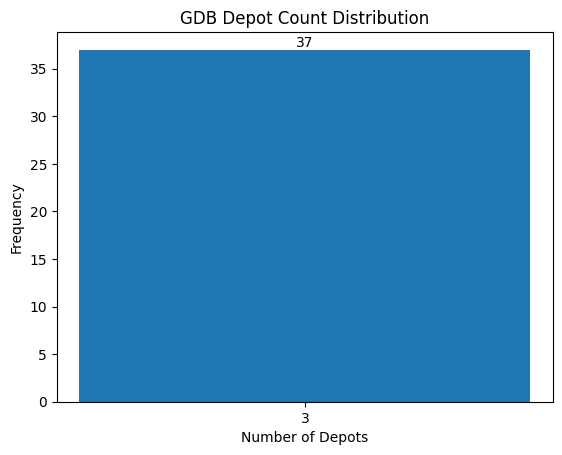

In [21]:
import os
import re
import matplotlib.pyplot as plt

# Base directory for balanced scenarios
base_dir = "Balanced_Failure_Scenarios"
# instances = ["gdb", "bccm", "eglese"]
instances = ["gdb"]

for inst in instances:
    folder = os.path.join(base_dir, f"{inst}_failure_scenarios_fourth")
    if not os.path.isdir(folder):
        print(f"[Warning] Folder not found: {folder}")
        continue

    depot_counts = []
    for fname in sorted(os.listdir(folder)):
        if fname.endswith(".txt"):
            path = os.path.join(folder, fname)
            with open(path, 'r') as f:
                for line in f:
                    if line.strip().startswith("DEPOT:"):
                        parts = line.split(":", 1)[1].strip()
                        tokens = [t for t in re.split(r'[, \t]+', parts) if t]
                        depot_counts.append(len(tokens))
                        break

    if not depot_counts:
        print(f"[Notice] No depots found in {folder}.")
        continue

    # Create histogram
    bins = range(min(depot_counts), max(depot_counts) + 2)
    fig, ax = plt.subplots()
    counts, bin_edges, patches = ax.hist(depot_counts, bins=bins)

    # Center x-ticks on bars
    centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
    ax.set_xticks(centers)
    ax.set_xticklabels([int(edge) for edge in bin_edges[:-1]])

    # Annotate counts above bars
    for count, patch in zip(counts, patches):
        if count > 0:
            x = patch.get_x() + patch.get_width() / 2
            ax.text(x, count, str(int(count)), ha='center', va='bottom')

    ax.set_title(f"{inst.upper()} Depot Count Distribution")
    ax.set_xlabel("Number of Depots")
    ax.set_ylabel("Frequency")
    plt.show()


In [4]:
import os
import re
import pandas as pd

def parse_stats(path):
    """
    Parse a scenario .txt file and return:
      - n_nodes: total vertices
      - n_edges: total edges (from header or count)
      - n_req: number of required edges
      - n_depots: number of depots
      - n_veh: number of vehicles
    """
    n_nodes = None
    n_edges = None
    n_req = 0
    n_nonreq = 0
    n_depots = 0
    n_veh = None

    section = None
    with open(path, 'r') as f:
        for line in f:
            s = line.strip()
            if not s:
                continue

            if s.startswith("NUMBER OF VERTICES:"):
                n_nodes = int(s.split(":", 1)[1].strip())
            elif s.startswith("NUMBER OF EDGES:"):
                n_edges = int(s.split(":", 1)[1].strip())
            elif s.startswith("LIST_REQUIRED_EDGES:"):
                section = 'req'
                continue
            elif s.startswith("LIST_NON_REQUIRED_EDGES:"):
                section = 'nonreq'
                continue
            elif s.endswith(":") and section in ('req', 'nonreq'):
                section = None
                continue

            if section == 'req' and s.startswith("("):
                n_req += 1
            elif section == 'nonreq' and s.startswith("("):
                n_nonreq += 1
            elif s.startswith("DEPOT:"):
                parts = s.split(":", 1)[1].strip()
                tokens = [t for t in re.split(r'[, \t]+', parts) if t]
                n_depots = len(tokens)
            elif s.startswith("NUMBER OF VEHICLES:"):
                try:
                    n_veh = int(s.split(":", 1)[1].strip())
                except ValueError:
                    pass

    if n_edges is None:
        n_edges = n_req + n_nonreq
    if n_veh is None:
        n_veh = n_depots

    return n_nodes, n_edges, n_req, n_depots, n_veh

# Directories
before_dir = "Updated_Failure_Scenarios"
after_dir = "Balanced_Failure_Scenarios"
instances = {'gdb': 37, 'bccm': 108, 'eglese': 112}

records = []
for inst, max_n in instances.items():
    for i in range(1, max_n + 1):
        rec = {'instance': inst, 'scenario': i}

        before_path = os.path.join(before_dir, f"{inst}_failure_scenarios", f"{inst}.{i}.txt")
        after_path  = os.path.join(after_dir,  f"{inst}_failure_scenarios", f"{inst}.{i}.txt")

        # parse before and after
        if os.path.exists(before_path):
            nb, eb, rb, db_before, vb_before = parse_stats(before_path)
        else:
            nb = eb = rb = db_before = vb_before = None

        if os.path.exists(after_path):
            na, ea, ra, db_after, vb_after = parse_stats(after_path)
        else:
            na = ea = ra = db_after = vb_after = None

        rec.update({
            'Nodes': nb,
            'Edges': eb,
            'Required edges': ra,
            'n_depots_before': db_before,
            'n_veh_before': vb_before,
            'n_depots_after': db_after,
            'n_veh_after': vb_after,
            'Percentage Required edges': (ra / eb * 100) if eb else None,
            'Percentage depots before': (db_before / nb * 100) if nb else None,
            'Percentage depots after': (db_after / nb * 100) if nb else None
        })
        records.append(rec)

df = pd.DataFrame.from_records(records)

# Summary table
summary = []
for inst, group in df.groupby('instance'):
    veh_vals = group['n_veh_after'].dropna()
    vehicles_range = f"{int(veh_vals.min())} - {int(veh_vals.max())}" if not veh_vals.empty else None
    avg_req_pct = group['Percentage Required edges'].mean()
    avg_dep_pct = group['Percentage depots after'].mean()
    summary.append({
        'instance': inst,
        'Number of vehicles range': vehicles_range,
        '% Average of edges which are required': avg_req_pct,
        '% Average of Nodes are depots': avg_dep_pct
    })
summary_df = pd.DataFrame(summary)

# Save to Excel using openpyxl engine
output_excel = "balanced_failure_stats.xlsx"
with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
    df.to_excel(writer, index=False, sheet_name='Details')
    summary_df.to_excel(writer, index=False, sheet_name='Summary')

print(f"Excel file saved to {output_excel}")


Excel file saved to balanced_failure_stats.xlsx


In [19]:
import os
import networkx as nx

def parse_text_file(file_path):
    G = nx.Graph()
    depots = []
    battery_capacity = None
    with open(file_path, 'r') as f:
        lines = f.readlines()
    current_section = None
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if line.startswith('NAME'):
            continue
        elif line.startswith('NUMBER OF VERTICES'):
            num_vertices = int(line.split(':')[1].strip())
            G.add_nodes_from(range(1, num_vertices + 1))
        elif line.startswith('VEHICLE CAPACITY'):
            # battery capacity is given in time units
            battery_capacity = float(line.split(':')[1].strip())
        elif line.startswith('LIST_REQUIRED_EDGES:'):
            current_section = 'required_edges'
        elif line.startswith('LIST_NON_REQUIRED_EDGES:'):
            current_section = 'non_required_edges'
        elif line.startswith('FAILURE_SCENARIO:'):
            current_section = 'failure_scenario'
        elif line.startswith('DEPOT:'):
            depots_line = line.split(':', 1)[1].strip()
            depots = [int(x.strip()) for x in depots_line.split(',')]
        else:
            if current_section in ('required_edges', 'non_required_edges'):
                u_v, rest = line.split(') ', 1)
                u_v = u_v.strip('(')
                u, v = map(int, u_v.split(','))
                weight = extract_weight(rest)
                required = (current_section == 'required_edges')
                G.add_edge(u, v, weight=weight, required=required)
    if battery_capacity is None:
        raise ValueError('VEHICLE CAPACITY not found in file')
    return G, depots, battery_capacity

def extract_weight(text):
    if 'edge weight' in text:
        weight_str = text.split('edge weight')[1].strip()
    elif 'cost' in text:
        weight_str = text.split('cost')[1].strip()
    else:
        print("[!] Warning: No edge weight found, using default 1.0")
        weight_str = '1.0'
    try:
        return float(weight_str)
    except:
        return 1.0


def select_k_depots(G, k):
    """
    Greedy k-center: pick k depot nodes so as to minimize the maximum distance
    from any node to its nearest depot (approximation).
    """
    # annotate edges with travel_time = weight
    for u, v, data in G.edges(data=True):
        data['travel_time'] = data.get('weight', 1.0)

    print(G.edges(data=True))
    # start from an arbitrary node
    centers = [next(iter(G.nodes()))]
    print(centers)
    # precompute all-pairs distances on demand
    while len(centers) < k:
        # compute for each node its distance to the nearest current center
        dist_to_nearest = nx.multi_source_dijkstra_path_length(G, centers, weight='travel_time')
        print(f"Distances to nearest center: {dist_to_nearest}")
        # pick the node furthest from any center
        farthest = max(dist_to_nearest.items(), key=lambda x: x[1])[0]
        centers.append(farthest)
        print(f"Selected center: {farthest}, total centers: {len(centers)}")
    return set(centers)


def select_k_depots_connected(G, k, battery_capacity):
    """
    Greedy k-center with connectivity constraint:
    • Every new depot must be within radius = battery_capacity/2 of some existing depot.
    • If no such node exists, fall back to the classic farthest-node choice.
    """
    # 1) annotate edges with travel_time
    for u, v, data in G.edges(data=True):
        data['travel_time'] = data.get('weight', 1.0)

    radius = battery_capacity / 2.0

    # 2) precompute coverage for speed (optional)
    #    coverage[n] = set of nodes within 'radius' of n
    coverage = {
        n: set(nx.single_source_dijkstra_path_length(G, n, cutoff=radius, weight='travel_time').keys())
        for n in G.nodes()
    }
    print(f"Coverage precomputed for {len(coverage)} nodes.")

    # 3) start with one arbitrary depot
    centers = [next(iter(G.nodes()))]

    print(f"Initial center: {centers[0]}")

    # 4) iteratively add depots until we have k
    while len(centers) < k:
        # distances from each node to its nearest current depot
        dist_to_nearest = nx.multi_source_dijkstra_path_length(G, centers, weight='travel_time')

        # 4a) standard farthest node
        farthest_node = max(dist_to_nearest, key=dist_to_nearest.get)

        # 4b) filter candidates that are within 'radius' of at least one center
        eligible = [
            n for n in G.nodes()
            if n not in centers
            and any(
                nx.shortest_path_length(G, n, c, weight='travel_time') <= radius
                for c in centers
            )
        ]

        if eligible:
            # pick among eligible the one that covers the most *new* nodes
            # (i.e. maximizes coverage[n] \ already_covered)
            already_covered = set().union(*(coverage[c] for c in centers))
            gains = {n: len(coverage[n] - already_covered) for n in eligible}
            best = max(gains, key=gains.get)
            centers.append(best)
        else:
            # no connected candidate: fall back to farthest
            print(f"[Warning] No connected depot found, using farthest node: {farthest_node}")
            centers.append(farthest_node)

    print(f"centers: {centers}, total centers: {len(centers)}")
    return set(centers)

def select_connected_cover(G, battery_capacity):
    """
    Phase 1: Greedy cover to ensure every node lies within C/2 of at least one depot.
    Phase 2: “Patch” any isolated depots so that each depot has at least one other depot
    within C/2 as well.
    Returns the final set of depot nodes.
    """
    # 1) annotate travel_time
    for u, v, data in G.edges(data=True):
        data['travel_time'] = data.get('weight', 1.0)

    radius = battery_capacity / 2.0

    # 2) precompute for every node the set of nodes within radius
    coverage = {
        n: set(nx.single_source_dijkstra_path_length(
            G, n, cutoff=radius, weight='travel_time'
        ).keys())
        for n in G.nodes()
    }

    # --- PHASE 1: cover all nodes at least once ---
    all_nodes = set(G.nodes())
    covered = set()
    depots = set()
    while covered != all_nodes:
        # pick the candidate that covers the most yet‐uncovered nodes
        best, best_gain = None, -1
        for n in G.nodes():
            if n in depots:
                continue
            gain = len(coverage[n] - covered)
            if gain > best_gain:
                best, best_gain = n, gain
        depots.add(best)
        covered |= coverage[best]

    # --- PHASE 2: ensure depot–depot connectivity at radius ---
    # while any depot has zero neighbors (within radius) among depots:
    changed = True
    while changed:
        changed = False
        for d in list(depots):
            # find other depots within radius of d
            nbrs = coverage[d] & depots - {d}
            if nbrs:
                continue  # already connected
            # d is isolated: pick one neighbor of d (within radius) to also become depot
            candidates = coverage[d] - depots
            if not candidates:
                continue  # no way to connect
            # choose the candidate that itself “sees” the most current depots
            v = max(candidates, key=lambda x: len(coverage[x] & depots))
            depots.add(v)
            changed = True

    return depots


def select_k_connected_cover(G, battery_capacity, k):
    """
    Pick exactly k depots so that:
      - Every node is within battery_capacity/2 of some depot.
      - Every depot has at least one other depot within battery_capacity/2.
    Greedy heuristic:
      1. Pick the node covering the most others.
      2. While len(depots)<k, add the node (not yet chosen) that
         - Is within radius of an existing depot (if possible), and
         - Covers the most *new* nodes.
      3. If after k you’re not covering all nodes, that’s a warning.
      4. Finally patch any isolated depot by swapping in a neighbor if needed.
    """
    # 1) annotate travel_time
    for u, v, data in G.edges(data=True):
        data['travel_time'] = data.get('weight', 1.0)

    radius = battery_capacity / 2.0

    # 2) precompute coverage balls
    coverage = {
        n: set(nx.single_source_dijkstra_path_length(
            G, n, cutoff=radius, weight='travel_time'
        ).keys())
        for n in G.nodes()
    }

    all_nodes = set(G.nodes())
    depots = []
    covered = set()

    # 3) seed with the node covering the most
    seed = max(G.nodes(), key=lambda n: len(coverage[n]))
    depots.append(seed)
    covered |= coverage[seed]

    # 4) greedy add until k
    while len(depots) < k:
        candidates = [n for n in G.nodes() if n not in depots]

        # try to enforce connectivity: only keep those within radius of any depot
        conn_cands = [n for n in candidates
                      if any(n in coverage[d] for d in depots)]
        if conn_cands:
            search_space = conn_cands
        else:
            # no connected candidate remains, fall back to all
            search_space = candidates

        # pick the one that covers the most *yet-uncovered* nodes
        best = max(search_space, key=lambda n: len(coverage[n] - covered))
        depots.append(best)
        covered |= coverage[best]

    # 5) patch coverage if needed
    if covered != all_nodes:
        missing = all_nodes - covered
        print(f"[Warning] after {k} depots, {len(missing)} nodes remain uncovered")

    # 6) ensure each depot has a buddy
    #    if any depot d has no other depot in its radius, swap it
    for d in list(depots):
        buddies = [d2 for d2 in depots if d2 != d and d in coverage[d2]]
        if buddies:
            continue  # already connected
        # pick a neighbor of d (within radius) that’s not a depot, swap in
        neighbors = [n for n in coverage[d] if n not in depots]
        if not neighbors:
            continue
        # choose the neighbor covering most of current depots
        swap_in = max(neighbors, key=lambda n: sum(1 for dd in depots if n in coverage[dd]))
        depots[depots.index(d)] = swap_in
    print(f"Depots - {depots}")
    return set(depots)

def update_gdb_instances(k):
    """
    For every GDB scenario, parse it, pick k depots & vehicles, and rewrite the file.
    """
    in_dir  = "Balanced_Failure_Scenarios/gdb_failure_scenarios"
    out_dir = "Balanced_Failure_Scenarios/gdb_failure_scenarios_fourth"
    os.makedirs(out_dir, exist_ok=True)

    for fname in os.listdir(in_dir):
        if not fname.endswith(".txt"):
            continue
        path_in  = os.path.join(in_dir,  fname)
        path_out = os.path.join(out_dir, fname)

        # --- parse graph & capacity exactly as before
        G, _, battery_capacity = parse_text_file(path_in)


        depots = select_k_connected_cover(G, battery_capacity, 3)
        # # --- choose exactly k depots
        # depots = select_k_depots_connected(G, k, battery_capacity)
        print()
        # --- rewrite file
        lines = open(path_in).read().splitlines(True)
        # strip old DEPOT and VEHICLE lines
        filtered = [l for l in lines
                    if not l.startswith("DEPOT:") 
                    and not l.startswith("NUMBER OF VEHICLES:")]

        # insert new VEHICLE count right after VEHICLE_CAPACITY
        for i, l in enumerate(filtered):
            if l.startswith("VEHICLE CAPACITY"):
                filtered.insert(i+1, f"NUMBER OF VEHICLES: {k}\n")
                break

        # insert new DEPOT list before edges
        for i, l in enumerate(filtered):
            if l.strip().startswith("("):
                filtered.insert(i, "DEPOT: " + ",".join(map(str, sorted(depots))) + "\n")
                break

        with open(path_out, "w") as f:
            f.writelines(filtered)

        print(f" → {fname}: vehicles={k}, depots={len(depots)}")

if __name__=="__main__":
    # e.g. bump from 2 to 4 vehicles
    update_gdb_instances(k=3)


Depots - [1, 7, 2]

 → gdb.1.txt: vehicles=3, depots=3
Depots - [1, 6, 2]

 → gdb.10.txt: vehicles=3, depots=3
Depots - [12, 1, 2]

 → gdb.11.txt: vehicles=3, depots=3
Depots - [5, 1, 2]

 → gdb.12.txt: vehicles=3, depots=3
Depots - [1, 2, 3]

 → gdb.13.txt: vehicles=3, depots=3
Depots - [5, 1, 2]

 → gdb.14.txt: vehicles=3, depots=3
Depots - [6, 8, 1]

 → gdb.15.txt: vehicles=3, depots=3
Depots - [1, 2, 3]

 → gdb.16.txt: vehicles=3, depots=3
Depots - [1, 2, 3]

 → gdb.17.txt: vehicles=3, depots=3
Depots - [1, 2, 3]

 → gdb.18.txt: vehicles=3, depots=3
Depots - [1, 2, 3]

 → gdb.19.txt: vehicles=3, depots=3
Depots - [1, 2, 3]

 → gdb.2.txt: vehicles=3, depots=3
Depots - [6, 1, 2]

 → gdb.20.txt: vehicles=3, depots=3
Depots - [1, 2, 3]

 → gdb.21.txt: vehicles=3, depots=3
Depots - [1, 2, 3]

 → gdb.22.txt: vehicles=3, depots=3
Depots - [1, 2, 3]

 → gdb.23.txt: vehicles=3, depots=3
Depots - [1, 2, 3]

 → gdb.24.txt: vehicles=3, depots=3
Depots - [1, 2, 3]

 → gdb.25.txt: vehicles=3, de